## Домашнее задание №4. Работа с NPV моделью

*Дата выдачи: 28.01.2026*

*Дедлайн: 02.02.2026 23:59*


### Задание: добавить страховку в NPV модель
- Страховка стоит 0.5% от лимита
- Подключена у 40% клиентов в статусе CUR и у 60% в статусе DLQ
- Возможно наступление страхового случая с вероятностью 0.1%, при подключенной страховке мы должны возместить всю сумму текущей задолженности

Вам нужно внести изменения в код ниже. Где – подсказывать не будем, это часть задания. Добавьте комментарий с указанием места, котороые вы поменяли.

### Класс модели

In [53]:
import numpy as np

class NPVModel:

    avg_missed_payments = 1.5
    recovery = 0.50
    dlq_penalty_amount = 500
    oper_costs = 100
    collection_costs = 600
    tax_rate = 0.20
    discounting_rate = 0.30
    eq_req = 0.125
    cost_of_funds = 0.16
    dlq_ratio = np.ones(101)*0.20
    dlq_ratio[0] = 0
    acquisition_cost = 1000

    # тут добавьл параметры страховки
    insurance_premium_rate = 0.005 # 0.5% от лимита
    insurance_share_cur = 0.4 # доля клиентов со страховкой среди CUR
    insurance_share_dlq = 0.6 # доля клиентов со страховкой среди DLQ
    insurance_claim_prob_month = 0.001  # 0.1% вероятность страхового случая месячная

    def __init__(self):
        pass

    def model_balance_calculations(self, amount, rate, term):
        '''
        Расчет модельных баланса, выплаченных процентов, регулярного платежа
        :param amount: Сумма кредита
        :param rate: Ставка
        :param term: Срок
        :return:
        balance : np.array(101) : остаток тела долга по кредиту на каждый месяц
        interest : np.array(101) : выплата по процентам каждый месяц
        regular_payment : float : размер регулярного платежа
        '''

        regular_payment = round(amount * (rate / 12) *\
                                (1 + (rate / 12)) / (1 - ((1 + rate / 12) ** (-term))))
        # График баланса и процентов
        balance = np.zeros(101)
        interest = np.zeros(101)
        balance[0] = amount

        for i in range(1, term + 1):
            int_payment = balance[i - 1] * rate / 12
            debt_payment = regular_payment - int_payment
            balance[i] = max(0, round(balance[i - 1] - debt_payment))
            interest[i] = int_payment
        return balance, interest, regular_payment

    def distribution_calc(self, portfolio_distribution, pd=None, pa=None):
        '''
        Расчет распределения по статусам
        :param portfolio_distribution: график распределения по статусам
        :return:
        cur_dist : np.array(101) : доля клиентов в статусе CUR на каждый месяц
        dlq_dist : np.array(101) : доля клиентов в статусе DLQ на каждый месяц
        act_dist : np.array(101) : доля клиентов в статусе ACT на каждый месяц
        def_dist : np.array(101) : доля клиентов в статусе DEF на каждый месяц
        clo_dist : np.array(101) : доля клиентов в статусе CLO на каждый месяц
        '''
        
        cur_dist = portfolio_distribution['CUR']
        dlq_dist = portfolio_distribution['DLQ']
        act_dist = cur_dist + dlq_dist
        def_dist = portfolio_distribution['DEF'] 
        clo_dist = portfolio_distribution['CLO']


        return cur_dist, dlq_dist, act_dist, def_dist, clo_dist

    def cur_balance_calc(self, model_balance, cur_dist):
        '''
        Расчет модельного баланса в статусе CUR
        :param model_balance: плановый график баланса
        :param cur_dist: доля клиентов в статусе CUR на каждый месяц
        :return:
        principal_balance_cur : np.array(101) : principal balance в статусе CUR
        gross_balance_cur : np.array(101) : gross balance в статусе CUR
        '''
        principal_balance_cur = model_balance*cur_dist
        gross_balance_cur = model_balance*cur_dist
        return principal_balance_cur, gross_balance_cur

    def dlq_balance_calc(self, model_balance, regular_payment, dlq_dist):
        '''
        Расчет модельного баланса в статусе DLQ
        :param model_balance: плановый график баланса
        :param regular_payment: размер регулярного платежа
        :param dlq_dist: доля клиентов в статусе DLQ на каждый месяц
        :return:
        principal_balance_dlq : np.array(101) : principal balance в статусе DLQ
        gross_balance_dlq : np.array(101) : gross balance в статусе DLQ
        '''
        principal_balance_dlq = np.append(model_balance[1:], model_balance[-1])*dlq_dist
        gross_balance_dlq = (model_balance + regular_payment*self.avg_missed_payments)*dlq_dist
        return principal_balance_dlq, gross_balance_dlq

    def act_balance_calc(self, principal_balance_cur, principal_balance_dlq, gross_balance_cur, gross_balance_dlq):
        '''
        Расчет модельного баланса в статусе ACT
        :param principal_balance_cur: principal balance в статусе CUR
        :param principal_balance_dlq: principal balance в статусе DLQ
        :param gross_balance_cur: principal balance в статусе CUR
        :param gross_balance_dlq: principal balance в статусе DLQ
        :param dlq_dist: доля клиентов в статусе DLQ на каждый месяц
        :return:
        principal_balance_act : np.array(101) : principal balance в статусе ACT
        gross_balance_act : np.array(101) : gross balance в статусе ACT
        '''
        principal_balance_act = principal_balance_cur + principal_balance_dlq
        gross_balance_act = gross_balance_cur + gross_balance_dlq
        return principal_balance_act, gross_balance_act

    def def_balance_calc(self, model_balance, regular_payment, def_dist):
        '''
        Расчет модельного баланса в статусе DEF
        :param model_balance: плановый график баланса
        :param regular_payment: размер регулярного платежа
        :param def_dist: доля клиентов в статусе DEF на каждый месяц
        :return:
        principal_balance_def : np.array(101) : principal balance в статусе DEF
        gross_balance_def : np.array(101) : gross balance в статусе DEF
        '''
        principal_balance_def = np.zeros(101)
        gross_balance_def = np.zeros(101)

        def_dist_change = def_dist[4:] - def_dist[3:-1]
        principal_balance_def[4:] = np.cumsum(model_balance[:-4] * def_dist_change)
        gross_balance_def[4:] = np.cumsum((model_balance[4:] + 4 * regular_payment) * def_dist_change)

        return principal_balance_def, gross_balance_def

    def profit_calc(self, principal_balance_act, principal_balance_def, term, rate, dlq_dist):
        '''

        :param principal_balance_act: principal balance в статусе ACT
        :param principal_balance_def: principal balance в статусе DEF
        :param term: срок кредита
        :param rate: тавка по кредиту
        :param dlq_dist: доля клиентов в статусе DLQ на каждый месяц
        :return:
        profit : np.array(101) : доход на каждый месяц
        '''
        interest_profit = principal_balance_act*rate/12
        penatly_profit = dlq_dist*self.dlq_penalty_amount

        new_def_balance = np.append(principal_balance_def[1:], 0) - principal_balance_def
        recovery_profit = new_def_balance*self.recovery

        profit = interest_profit + recovery_profit + penatly_profit
        profit[term+1:] = 0

        return profit

    def loss_calc(self, gross_balance_act, principal_balance_def, term, act_dist, dlq_dist, def_dist):
        '''

        :param gross_balance_act: gross balance в статусе ACT
        :param principal_balance_def: principal balance в статусе DEF
        :param term: срок кредита
        :param act_dist: доля клиентов в статусе ACT на каждый месяц
        :param dlq_dist: доля клиентов в статусе DLQ на каждый месяц
        :param def_dist: доля клиентов в статусе DEF на каждый месяц
        :return:
        loss : np.array(101) : лосс на каждый месяц
        '''
        oper_loss = np.append(act_dist[1:], 0)*self.oper_costs
        loan_loss =  principal_balance_def - np.append(0, principal_balance_def[:-1])
        collection_loss = (np.append(dlq_dist[1:], 0) + np.append(def_dist[1:], 0))*self.collection_costs

        prev_gross_balance_act = np.append(gross_balance_act[0], gross_balance_act[1:])
        cost_of_funds_loss = prev_gross_balance_act*(1 - self.eq_req)*self.cost_of_funds/12

        loss = loan_loss + cost_of_funds_loss + oper_loss + collection_loss
        loss[term+1:] = 0

        return loss, loan_loss, cost_of_funds_loss, oper_loss, collection_loss

    def assets_liabilities_calc(self, gross_balance_act):
        '''

        :param gross_balance_act: gross balance в статусе ACT
        :return:
        assets : np.array(101) : активы в проекте
        eq_req_curve : np.array(101) : активы, обеспеченные капиталом
        fund_req_curve : np.array(101) : активы, обеспеченные фондами
        '''

        # assets
        assets = gross_balance_act

        #liabilities
        eq_req_curve = assets*self.eq_req
        fund_req_curve = assets*(1 - self.eq_req)

        return assets, eq_req_curve, fund_req_curve

    def niat_calc(self, profit, loss):
        '''
        Расчет NIAT
        :param profit: суммарный доход на каждый месяц
        :param loss: суммарный лосс на каждый месяц
        :return:
        nibt : np.array(101) : прибыль до налогообложения
        niat : np.array(101) : прибыль после налогообложения
        tax : np.array(101) : налог в каждом месяце
        '''

        nibt = profit - loss
        tax = nibt*self.tax_rate
        niat = nibt - tax

        return nibt, niat, tax

    def cashflow_calc(self, principal_balance_act, principal_balance_def, amount, profit,
                      cost_of_funds_loss, oper_costs, collection_costs, tax, niat, eq_req_curve, fund_req_curve):
        '''
        Расчет денежных потоков
        :param principal_balance_act: principal balance в статусе DEF
        :param principal_balance_def: principal balance в статусе DEF
        :param amount: срок кредита
        :param profit: доход на каждый месяц
        :param cost_of_funds_loss: лоссы на фондирование
        :param oper_costs: операционные расходы
        :param collection_costs: расходы на коллекшн
        :param tax: налог в каждом месяце
        :param niat: доход после налогообложения
        :param eq_req_curve: активы, обеспеченные капиталом
        :param fund_req_curve: активы, обеспеченные фондами
        :return:
        cf_to_client : np.array(101) : денежный поток к клиенту
        cf_to_shareholders : np.array(101) : денежный поток к акционерам
        cf_to_debtholders : np.array(101) : денежный поток к фондам
        cf_to_cost_and_tax : np.array(101) : денежный поток на косты и налоги
        '''
        # client
        delta_principal_balance_act = (np.append(0, principal_balance_act[:100]) - principal_balance_act)
        delta_principal_balance_def = (np.append(0, principal_balance_def[:100]) - principal_balance_def)
        repayments = delta_principal_balance_act - delta_principal_balance_def + profit
        cf_to_client = np.append(amount, -repayments[1:])

        # debtoholder
        fund_req_ch = fund_req_curve - np.append(fund_req_curve[0], fund_req_curve[:-1])
        fund_req_change = np.append(fund_req_curve[0], fund_req_ch[1:])
        cf_to_debtholders = cost_of_funds_loss - fund_req_change

        # shareholders
        eq_req_ch = eq_req_curve - np.append(eq_req_curve[0], eq_req_curve[:-1])
        cf_to_shareholders = niat - np.append(eq_req_curve[0], eq_req_ch[1:])

        # cost and tax
        cf_to_cost_and_tax = oper_costs + collection_costs + tax

        return cf_to_client, cf_to_shareholders, cf_to_debtholders, cf_to_cost_and_tax

    def npv_calc(self, amount, rate, term, portfolio_distribution, pd=None, pa=None):
        '''
        Расчет NPV
        :param amount: сумма кредита
        :param rate: ставка по кредиту
        :param term: срок кредита
        :param portfolio_distribution: график распределения по статусам
        :param pd: вероятность дефолта к 12-ому месяцу
        :param pa: вероятность полного досрочного погашения к 6-ому месяцу
        :return: npv: чистая приведенная стоимость кредита
        '''

        # Считаем балансы
        model_balance, interest, regular_payment =  self.model_balance_calculations(amount, rate, term)

        # Считаем распределение
        cur_dist, dlq_dist, act_dist, def_dist, clo_dist = self.distribution_calc(portfolio_distribution)

        # Считаем балансы
        principal_balance_cur, gross_balance_cur = self.cur_balance_calc(model_balance, cur_dist)
        principal_balance_dlq, gross_balance_dlq = self.dlq_balance_calc(model_balance, regular_payment, dlq_dist)
        principal_balance_act, gross_balance_act = self.act_balance_calc(principal_balance_cur, principal_balance_dlq, gross_balance_cur, gross_balance_dlq)
        principal_balance_def, gross_balance_def = self.def_balance_calc(model_balance, regular_payment, def_dist)

        # Считаем профиты
        profit = self.profit_calc(principal_balance_act, principal_balance_def, term, rate, dlq_dist)
        loss, loan_loss, cost_of_funds_loss, oper_loss, collection_loss = self.loss_calc(
            gross_balance_act, principal_balance_def, term, act_dist, dlq_dist, def_dist
        )

        # УЧЕТ СТРАХОВКИ
        
        # прибыль со страховки: 0.5% от лимита, подключена у 40% CUR и 60% DLQ
        insured_share_curve = (cur_dist * self.insurance_share_cur) + (dlq_dist * self.insurance_share_dlq)
        insurance_income = amount * self.insurance_premium_rate * insured_share_curve

        # выплаты при наступлении страхового случая: 0.1% месячная вероятность * "текущая задолженность" у застрахованных
        # "текущая задолженность" как gross_balance статуса (для DLQ включает хвост просрочки)
        insured_gross_debt = (gross_balance_cur * self.insurance_share_cur) + (gross_balance_dlq * self.insurance_share_dlq)
        insurance_payout = insured_gross_debt * self.insurance_claim_prob_month

        # обрезал после срока кредита
        insurance_income[term+1:] = 0
        insurance_payout[term+1:] = 0

        # учет страховки: прибыль со страховки в доход, выплата за страховой случай в расход
        profit = profit + insurance_income
        loss = loss + insurance_payout

        # КОНЕЦ

        nibt, niat, tax = self.niat_calc(profit, loss)

        # Считаем активы и денежные потоки
        assets, eq_req_curve, fund_req_curve = self.assets_liabilities_calc(gross_balance_act)
        cf_to_client, cf_to_shareholders, cf_to_debtholders, cf_to_cost_and_tax =\
            self.cashflow_calc(principal_balance_act, principal_balance_def, amount, profit, cost_of_funds_loss, oper_loss, collection_loss,
                               tax, niat, eq_req_curve, fund_req_curve)

        # Считаем NPV
        disc_curve = np.array([1 / ((1 + self.discounting_rate) ** (i / 12.)) for i in range(101)])
        pv = np.round(np.sum(disc_curve * cf_to_shareholders)).astype(int)
        npv = pv - self.acquisition_cost

        return npv

### Пример использования модели

In [54]:
cur_dist = np.zeros(101)
dlq_dist = np.zeros(101)
clo_dist = np.zeros(101)
def_dist = np.zeros(101)

dlq_dist[1:12] += 0.05

def_dist[6:] += 0.03
def_dist[9:] += 0.03

def_dist[12:] += dlq_dist[11]

clo_dist[3:] += 0.10
clo_dist[6:] += 0.10
clo_dist[12:] = 1 - def_dist[12]

cur_dist = 1 - def_dist - clo_dist - dlq_dist

portfolio_distribution = {
    'CUR' : cur_dist,
    'DLQ' : dlq_dist,
    'DEF' : def_dist,
    'CLO' : clo_dist
         }

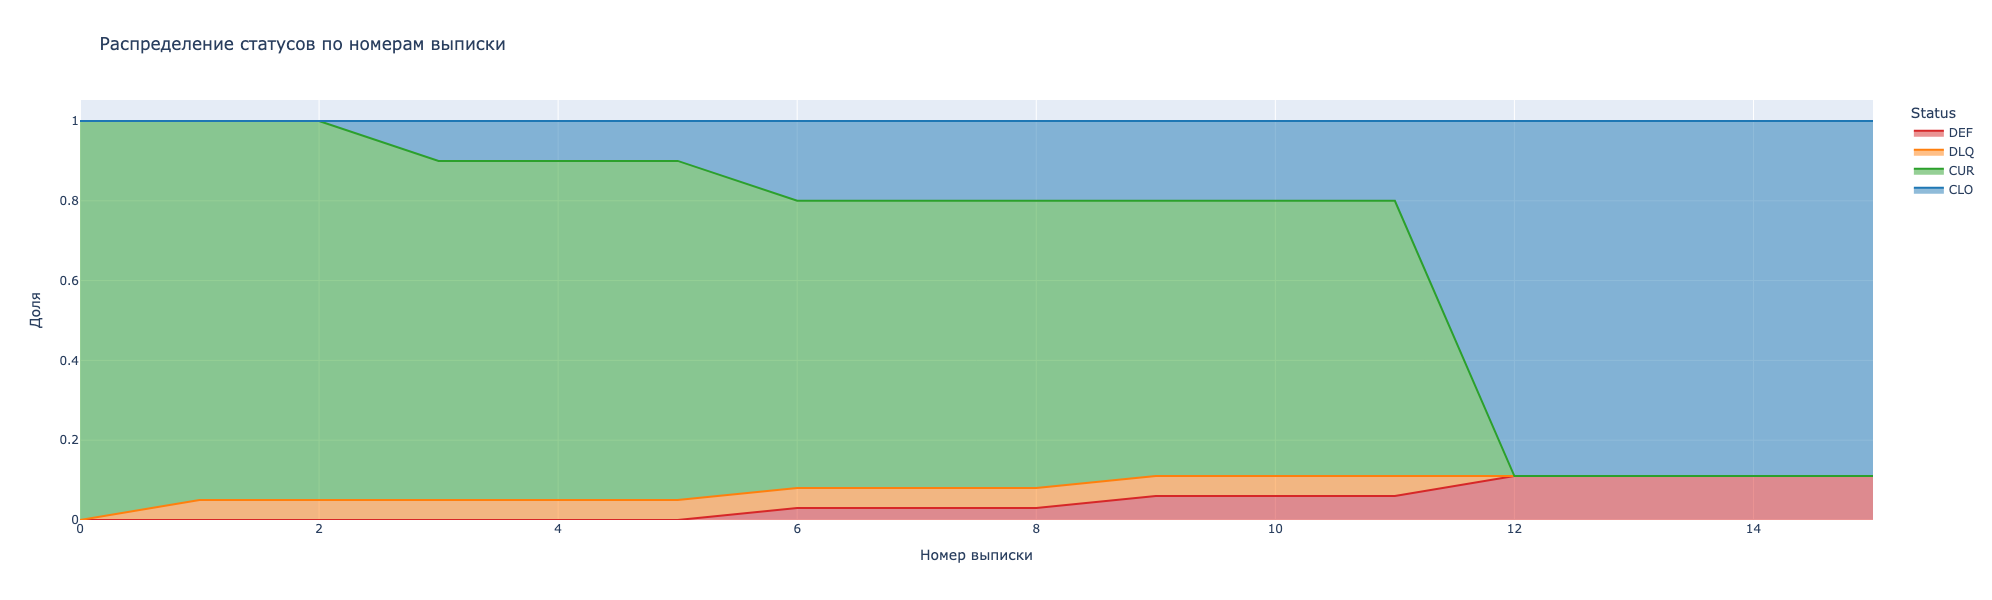

In [55]:
import plotly.express as px
import pandas as pd

df = pd.DataFrame({
    'CUR': cur_dist,
    'DLQ': dlq_dist,
    'DEF': def_dist,
    'CLO': clo_dist
})

df = df.reset_index().rename(columns={'index': 'Номер выписки'})
df = df.melt(id_vars='Номер выписки', value_vars=['DEF', 'DLQ', 'CUR', 'CLO'], 
             var_name='Status', value_name='Доля')

fig = px.area(df, x='Номер выписки', y='Доля', color='Status', 
              title='Распределение статусов по номерам выписки',
              color_discrete_map={
                  'DEF': '#D62728',
                  'DLQ': '#FF7F0E',
                  'CUR': '#2CA02C',
                  'CLO': '#1F77B4',
              },
              category_orders={'Status': ['DEF', 'DLQ', 'CUR', 'CLO']}
             )

fig.update_layout(height=600)
fig.update_xaxes(range=[0, 15])

fig.show()

In [56]:
model = NPVModel()
model.npv_calc(amount=500000, term=12, rate=0.25, portfolio_distribution=portfolio_distribution)

np.int64(6969)

Страховка меняет NPV двумя эффектами. Она даёт дополнительный доход в виде выплат от клиентов, поэтому NPV растёт. С другой стороны, страховка добавляет риск страховых выплат, и эти выплаты увеличиваются, если увеличивается баланс кредита и доля клиентов в просрочке(увеличиваются хвосты DLQ). В итоге NPV увеличивается, если ожидаемые выплаты от клиентов перекрывают ожидаемые страховые выплаты, и уменьшается, если страховые выплаты растут быстрее выплат клиентов - обычно это происходит при ухудшении качества портфеля и росте DLQ.

### Место для комментариев

## Задание на оценку чувствительности модели(сделал для модели до изменений)

In [57]:
import numpy as np

class NPVModel:

    avg_missed_payments = 1.5
    recovery = 0.50
    dlq_penalty_amount = 500
    oper_costs = 100
    collection_costs = 600
    tax_rate = 0.20
    discounting_rate = 0.30
    eq_req = 0.125
    cost_of_funds = 0.16
    dlq_ratio = np.ones(101)*0.20
    dlq_ratio[0] = 0
    acquisition_cost = 1000

    def __init__(self):
        pass

    def model_balance_calculations(self, amount, rate, term):
        '''
        Расчет модельных баланса, выплаченных процентов, регулярного платежа
        :param amount: Сумма кредита
        :param rate: Ставка
        :param term: Срок
        :return:
        balance : np.array(101) : остаток тела долга по кредиту на каждый месяц
        interest : np.array(101) : выплата по процентам каждый месяц
        regular_payment : float : размер регулярного платежа
        '''

        regular_payment = round(amount * (rate / 12) *\
                                (1 + (rate / 12)) / (1 - ((1 + rate / 12) ** (-term))))
        # График баланса и процентов
        balance = np.zeros(101)
        interest = np.zeros(101)
        balance[0] = amount

        for i in range(1, term + 1):
            int_payment = balance[i - 1] * rate / 12
            debt_payment = regular_payment - int_payment
            balance[i] = max(0, round(balance[i - 1] - debt_payment))
            interest[i] = int_payment
        return balance, interest, regular_payment

    def distribution_calc(self, portfolio_distribution, pd=None, pa=None):
        '''
        Расчет распределения по статусам
        :param portfolio_distribution: график распределения по статусам
        :return:
        cur_dist : np.array(101) : доля клиентов в статусе CUR на каждый месяц
        dlq_dist : np.array(101) : доля клиентов в статусе DLQ на каждый месяц
        act_dist : np.array(101) : доля клиентов в статусе ACT на каждый месяц
        def_dist : np.array(101) : доля клиентов в статусе DEF на каждый месяц
        clo_dist : np.array(101) : доля клиентов в статусе CLO на каждый месяц
        '''
        
        cur_dist = portfolio_distribution['CUR']
        dlq_dist = portfolio_distribution['DLQ']
        act_dist = cur_dist + dlq_dist
        def_dist = portfolio_distribution['DEF'] 
        clo_dist = portfolio_distribution['CLO']


        return cur_dist, dlq_dist, act_dist, def_dist, clo_dist

    def cur_balance_calc(self, model_balance, cur_dist):
        '''
        Расчет модельного баланса в статусе CUR
        :param model_balance: плановый график баланса
        :param cur_dist: доля клиентов в статусе CUR на каждый месяц
        :return:
        principal_balance_cur : np.array(101) : principal balance в статусе CUR
        gross_balance_cur : np.array(101) : gross balance в статусе CUR
        '''
        principal_balance_cur = model_balance*cur_dist
        gross_balance_cur = model_balance*cur_dist
        return principal_balance_cur, gross_balance_cur

    def dlq_balance_calc(self, model_balance, regular_payment, dlq_dist):
        '''
        Расчет модельного баланса в статусе DLQ
        :param model_balance: плановый график баланса
        :param regular_payment: размер регулярного платежа
        :param dlq_dist: доля клиентов в статусе DLQ на каждый месяц
        :return:
        principal_balance_dlq : np.array(101) : principal balance в статусе DLQ
        gross_balance_dlq : np.array(101) : gross balance в статусе DLQ
        '''
        principal_balance_dlq = np.append(model_balance[1:], model_balance[-1])*dlq_dist
        gross_balance_dlq = (model_balance + regular_payment*self.avg_missed_payments)*dlq_dist
        return principal_balance_dlq, gross_balance_dlq

    def act_balance_calc(self, principal_balance_cur, principal_balance_dlq, gross_balance_cur, gross_balance_dlq):
        '''
        Расчет модельного баланса в статусе ACT
        :param principal_balance_cur: principal balance в статусе CUR
        :param principal_balance_dlq: principal balance в статусе DLQ
        :param gross_balance_cur: principal balance в статусе CUR
        :param gross_balance_dlq: principal balance в статусе DLQ
        :param dlq_dist: доля клиентов в статусе DLQ на каждый месяц
        :return:
        principal_balance_act : np.array(101) : principal balance в статусе ACT
        gross_balance_act : np.array(101) : gross balance в статусе ACT
        '''
        principal_balance_act = principal_balance_cur + principal_balance_dlq
        gross_balance_act = gross_balance_cur + gross_balance_dlq
        return principal_balance_act, gross_balance_act

    def def_balance_calc(self, model_balance, regular_payment, def_dist):
        '''
        Расчет модельного баланса в статусе DEF
        :param model_balance: плановый график баланса
        :param regular_payment: размер регулярного платежа
        :param def_dist: доля клиентов в статусе DEF на каждый месяц
        :return:
        principal_balance_def : np.array(101) : principal balance в статусе DEF
        gross_balance_def : np.array(101) : gross balance в статусе DEF
        '''
        principal_balance_def = np.zeros(101)
        gross_balance_def = np.zeros(101)

        def_dist_change = def_dist[4:] - def_dist[3:-1]
        principal_balance_def[4:] = np.cumsum(model_balance[:-4] * def_dist_change)
        gross_balance_def[4:] = np.cumsum((model_balance[4:] + 4 * regular_payment) * def_dist_change)

        return principal_balance_def, gross_balance_def

    def profit_calc(self, principal_balance_act, principal_balance_def, term, rate, dlq_dist):
        '''

        :param principal_balance_act: principal balance в статусе ACT
        :param principal_balance_def: principal balance в статусе DEF
        :param term: срок кредита
        :param rate: тавка по кредиту
        :param dlq_dist: доля клиентов в статусе DLQ на каждый месяц
        :return:
        profit : np.array(101) : доход на каждый месяц
        '''
        interest_profit = principal_balance_act*rate/12
        penatly_profit = dlq_dist*self.dlq_penalty_amount

        new_def_balance = np.append(principal_balance_def[1:], 0) - principal_balance_def
        recovery_profit = new_def_balance*self.recovery

        profit = interest_profit + recovery_profit + penatly_profit
        profit[term+1:] = 0

        return profit

    def loss_calc(self, gross_balance_act, principal_balance_def, term, act_dist, dlq_dist, def_dist):
        '''

        :param gross_balance_act: gross balance в статусе ACT
        :param principal_balance_def: principal balance в статусе DEF
        :param term: срок кредита
        :param act_dist: доля клиентов в статусе ACT на каждый месяц
        :param dlq_dist: доля клиентов в статусе DLQ на каждый месяц
        :param def_dist: доля клиентов в статусе DEF на каждый месяц
        :return:
        loss : np.array(101) : лосс на каждый месяц
        '''
        oper_loss = np.append(act_dist[1:], 0)*self.oper_costs
        loan_loss =  principal_balance_def - np.append(0, principal_balance_def[:-1])
        collection_loss = (np.append(dlq_dist[1:], 0) + np.append(def_dist[1:], 0))*self.collection_costs

        prev_gross_balance_act = np.append(gross_balance_act[0], gross_balance_act[1:])
        cost_of_funds_loss = prev_gross_balance_act*(1 - self.eq_req)*self.cost_of_funds/12

        loss = loan_loss + cost_of_funds_loss + oper_loss + collection_loss
        loss[term+1:] = 0

        return loss, loan_loss, cost_of_funds_loss, oper_loss, collection_loss

    def assets_liabilities_calc(self, gross_balance_act):
        '''

        :param gross_balance_act: gross balance в статусе ACT
        :return:
        assets : np.array(101) : активы в проекте
        eq_req_curve : np.array(101) : активы, обеспеченные капиталом
        fund_req_curve : np.array(101) : активы, обеспеченные фондами
        '''

        # assets
        assets = gross_balance_act

        #liabilities
        eq_req_curve = assets*self.eq_req
        fund_req_curve = assets*(1 - self.eq_req)

        return assets, eq_req_curve, fund_req_curve

    def niat_calc(self, profit, loss):
        '''
        Расчет NIAT
        :param profit: суммарный доход на каждый месяц
        :param loss: суммарный лосс на каждый месяц
        :return:
        nibt : np.array(101) : прибыль до налогообложения
        niat : np.array(101) : прибыль после налогообложения
        tax : np.array(101) : налог в каждом месяце
        '''

        nibt = profit - loss
        tax = nibt*self.tax_rate
        niat = nibt - tax

        return nibt, niat, tax

    def cashflow_calc(self, principal_balance_act, principal_balance_def, amount, profit,
                      cost_of_funds_loss, oper_costs, collection_costs, tax, niat, eq_req_curve, fund_req_curve):
        '''
        Расчет денежных потоков
        :param principal_balance_act: principal balance в статусе DEF
        :param principal_balance_def: principal balance в статусе DEF
        :param amount: срок кредита
        :param profit: доход на каждый месяц
        :param cost_of_funds_loss: лоссы на фондирование
        :param oper_costs: операционные расходы
        :param collection_costs: расходы на коллекшн
        :param tax: налог в каждом месяце
        :param niat: доход после налогообложения
        :param eq_req_curve: активы, обеспеченные капиталом
        :param fund_req_curve: активы, обеспеченные фондами
        :return:
        cf_to_client : np.array(101) : денежный поток к клиенту
        cf_to_shareholders : np.array(101) : денежный поток к акционерам
        cf_to_debtholders : np.array(101) : денежный поток к фондам
        cf_to_cost_and_tax : np.array(101) : денежный поток на косты и налоги
        '''
        # client
        delta_principal_balance_act = (np.append(0, principal_balance_act[:100]) - principal_balance_act)
        delta_principal_balance_def = (np.append(0, principal_balance_def[:100]) - principal_balance_def)
        repayments = delta_principal_balance_act - delta_principal_balance_def + profit
        cf_to_client = np.append(amount, -repayments[1:])

        # debtoholder
        fund_req_ch = fund_req_curve - np.append(fund_req_curve[0], fund_req_curve[:-1])
        fund_req_change = np.append(fund_req_curve[0], fund_req_ch[1:])
        cf_to_debtholders = cost_of_funds_loss - fund_req_change

        # shareholders
        eq_req_ch = eq_req_curve - np.append(eq_req_curve[0], eq_req_curve[:-1])
        cf_to_shareholders = niat - np.append(eq_req_curve[0], eq_req_ch[1:])

        # cost and tax
        cf_to_cost_and_tax = oper_costs + collection_costs + tax

        return cf_to_client, cf_to_shareholders, cf_to_debtholders, cf_to_cost_and_tax

    def npv_calc(self, amount, rate, term, portfolio_distribution, pd=None, pa=None):
        '''
        Расчет NPV
        :param amount: сумма кредита
        :param rate: ставка по кредиту
        :param term: срок кредита
        :param portfolio_distribution: график распределения по статусам
        :param pd: вероятность дефолта к 12-ому месяцу
        :param pa: вероятность полного досрочного погашения к 6-ому месяцу
        :return: npv: чистая приведенная стоимость кредита
        '''

        # Считаем балансы
        model_balance, interest, regular_payment =  self.model_balance_calculations(amount, rate, term)

        # Считаем распределение
        cur_dist, dlq_dist, act_dist, def_dist, clo_dist = self.distribution_calc(portfolio_distribution)

        # Считаем балансы
        principal_balance_cur, gross_balance_cur = self.cur_balance_calc(model_balance, cur_dist)
        principal_balance_dlq, gross_balance_dlq = self.dlq_balance_calc(model_balance, regular_payment, dlq_dist)
        principal_balance_act, gross_balance_act = self.act_balance_calc(principal_balance_cur, principal_balance_dlq, gross_balance_cur, gross_balance_dlq)
        principal_balance_def, gross_balance_def = self.def_balance_calc(model_balance, regular_payment, def_dist)

        # Считаем профиты
        profit = self.profit_calc(principal_balance_act, principal_balance_def, term, rate, dlq_dist)
        loss, loan_loss, cost_of_funds_loss, oper_loss, collection_loss = self.loss_calc(gross_balance_act, principal_balance_def,
                                                                                                                  term, act_dist, dlq_dist, def_dist)
        nibt, niat, tax = self.niat_calc(profit, loss)

        # Считаем активы и денежные потоки
        assets, eq_req_curve, fund_req_curve = self.assets_liabilities_calc(gross_balance_act)
        cf_to_client, cf_to_shareholders, cf_to_debtholders, cf_to_cost_and_tax =\
            self.cashflow_calc(principal_balance_act, principal_balance_def, amount, profit, cost_of_funds_loss, oper_loss, collection_loss,
                               tax, niat, eq_req_curve, fund_req_curve)

        # Считаем NPV
        disc_curve = np.array([1 / ((1 + self.discounting_rate) ** (i / 12.)) for i in range(101)])
        pv = np.round(np.sum(disc_curve * cf_to_shareholders)).astype(int)
        npv = pv - self.acquisition_cost

        return npv

### Чувствительно к сумме кредита

In [58]:
amount_grid = range(100_000, 1_100_000, 100_000)

model = NPVModel()

for i in amount_grid:
    npv = model.npv_calc(amount=i, term=12, rate=0.25, portfolio_distribution=portfolio_distribution)
    print(f'Сумма кредита: {i}. NPV: {npv}')

Сумма кредита: 100000. NPV: -1450
Сумма кредита: 200000. NPV: -998
Сумма кредита: 300000. NPV: -545
Сумма кредита: 400000. NPV: -92
Сумма кредита: 500000. NPV: 361
Сумма кредита: 600000. NPV: 814
Сумма кредита: 700000. NPV: 1267
Сумма кредита: 800000. NPV: 1720
Сумма кредита: 900000. NPV: 2173
Сумма кредита: 1000000. NPV: 2626


NPV растёт с ростом суммы кредита, потому что почти все основные денежные потоки в модели масштабируются вместе с ней: процентный доход считается от баланса, так же пропорционально растут потери по дефолтам, стоимость фондирования, требование по капиталу. Но при этом есть фиксированные элементы, которые не растут вместе с суммой. Поэтому при маленьких суммах кредита фиксированные затраты сильнее превышают заработок, а при увеличении суммы кредита они становятся менее заметными

### Чувствительность к сроку кредита

In [59]:
term_grid = range(6, 37, 6)

model = NPVModel()

for i in term_grid:
    npv = model.npv_calc(amount=500_000, term=i, rate=0.25, portfolio_distribution=portfolio_distribution)
    print(f'Срок кредита: {i} мес. NPV: {npv}')

Срок кредита: 6 мес. NPV: 1746
Срок кредита: 12 мес. NPV: 361
Срок кредита: 18 мес. NPV: 653
Срок кредита: 24 мес. NPV: 716
Срок кредита: 30 мес. NPV: 697
Срок кредита: 36 мес. NPV: 647


При увеличении срока кредита растёт суммарный процентный доход, так как проценты начисляются дольше, но вместе с этим увеличиваются операционные расходы, стоимость фондирования и накапливаются кредитные потери, усиливается эффект дисконтирования. Из-за этого короткий срок (6 месяцев) даёт высокий NPV за счёт быстрого возврата денег, при среднем сроке NPV падает, а затем частично восстанавливается, когда процентный доход начинает перекрывать издержки

### Чувствительность к ставке

In [60]:
rate_grid = [0.15, 0.20, 0.25, 0.30, 0.35]

model = NPVModel()

for i in rate_grid:
    npv = model.npv_calc(amount=500_000, term=12, rate=i, portfolio_distribution=portfolio_distribution)
    print(f'Ставка: {i:.0%}. NPV: {npv}')

Ставка: 15%. NPV: -17899
Ставка: 20%. NPV: -8794
Ставка: 25%. NPV: 361
Ставка: 30%. NPV: 9559
Ставка: 35%. NPV: 18790


NPV растёт с увеличением процентной ставки, потому что основной источник дохода - процентный доход, который пропорционален ставке и начисляется на остаток долга

### Чувствительность к доле дефолтников

In [61]:
def_grid = [0.5, 0.75, 1.0, 1.25, 1.5]

model = NPVModel()

for k in def_grid:
    portfolio_dist_adj = {
        'CUR': portfolio_distribution['CUR'].copy(),
        'DLQ': portfolio_distribution['DLQ'].copy(),
        'DEF': portfolio_distribution['DEF'].copy(),
        'CLO': portfolio_distribution['CLO'].copy()
    }
    portfolio_dist_adj['DEF'] = portfolio_dist_adj['DEF'] * k
    portfolio_dist_adj['CUR'] = (
        portfolio_dist_adj['CUR']
        - (portfolio_dist_adj['DEF'] - portfolio_distribution['DEF'])
    )

    npv = model.npv_calc(amount=500_000, term=12, rate=0.25, portfolio_distribution=portfolio_dist_adj)
    print(f'Множитель DEF: {k}. NPV: {npv}')

Множитель DEF: 0.5. NPV: 5431
Множитель DEF: 0.75. NPV: 2896
Множитель DEF: 1.0. NPV: 361
Множитель DEF: 1.25. NPV: -2173
Множитель DEF: 1.5. NPV: -4708


NPV уменьшается при росте доли дефолтников, потому что дефолты напрямую увеличивают потери по телу кредита и расходы на взыскание, а также уменьшают активный баланс, с которого начисляются проценты

### Чувствительность к доле полных закрытий

In [62]:
clo_grid = [0.5, 0.75, 1.0, 1.25, 1.5]

model = NPVModel()

for k in clo_grid:
    portfolio_dist_adj = {
        'CUR': portfolio_distribution['CUR'].copy(),
        'DLQ': portfolio_distribution['DLQ'].copy(),
        'DEF': portfolio_distribution['DEF'].copy(),
        'CLO': portfolio_distribution['CLO'].copy()
    }
    portfolio_dist_adj['CLO'] = portfolio_dist_adj['CLO'] * k
    portfolio_dist_adj['CUR'] = (
        portfolio_dist_adj['CUR']
        - (portfolio_dist_adj['CLO'] - portfolio_distribution['CLO'])
    )

    npv = model.npv_calc(amount=500_000, term=12, rate=0.25, portfolio_distribution=portfolio_dist_adj)
    print(f'Множитель CUR: {k}. NPV: {npv}')

Множитель CUR: 0.5. NPV: 821
Множитель CUR: 0.75. NPV: 591
Множитель CUR: 1.0. NPV: 361
Множитель CUR: 1.25. NPV: 131
Множитель CUR: 1.5. NPV: -99


NPV снижается при росте доли полных закрытий, потому что при досрочном погашении кредит быстрее исчезает из портфеля: активный баланс сокращается, проценты начисляются на меньшее количество месяцев, и общий процентный доход уменьшается

### Чувсительности к доле капитала к выдаче

In [63]:
eq_grid = [0.05, 0.10, 0.125, 0.15, 0.20, 0.25]

model = NPVModel()

for i in eq_grid:
    model.eq_req = i
    npv = model.npv_calc(amount=500_000, term=12, rate=0.25, portfolio_distribution=portfolio_distribution)
    print(f'Доля капитала (eq_req): {i:.3f}. NPV: {npv}')

Доля капитала (eq_req): 0.050. NPV: 2676
Доля капитала (eq_req): 0.100. NPV: 1133
Доля капитала (eq_req): 0.125. NPV: 361
Доля капитала (eq_req): 0.150. NPV: -410
Доля капитала (eq_req): 0.200. NPV: -1953
Доля капитала (eq_req): 0.250. NPV: -3496


NPV падает при росте доли капитала eq_req, потому что чем больше капитала мы обязаны держать под выдачу, тем больше денег замораживается в проекте и не выходит в денежный поток к акционерам